# Импортирование необходимых библиотек

In [546]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [547]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [548]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [549]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

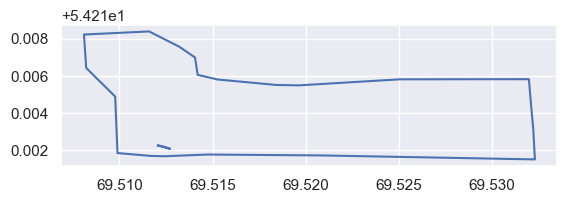

In [550]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [551]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [552]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Доступные базы данных (Спутиковые базы!!!)

In [553]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


# Выбор одной из доступных баз данных

In [554]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

# Составление запросов

In [555]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DN"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in bands_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
evalscript_all_bands = evalscript_all_bands.format(**settings)

In [556]:
evalscript_aux_data = """
    //VERSION=3

    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DEGREES"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in aux_data_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
evalscript_aux_data = evalscript_aux_data.format(**settings)

# Снимки на даты (с 01.05.2023 по 31.08.2023)

In [557]:
time_interval = "2020-05-01", "2020-08-31"

search_iterator = catalog.search(
    data_collection,
    bbox=pasture_bbox,
    time=time_interval,
    filter="eo:cloud_cover <= 100",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

# results

Total number of results: 49


In [558]:
time_difference = datetime.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

# unique_acquisitions

In [559]:
all_bands_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    all_bands_process_requests.append(request)

In [560]:
aux_data_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_aux_data,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    aux_data_process_requests.append(request)

In [561]:
%%time

client = SentinelHubDownloadClient(config=config)
all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
all_bands_data = client.download(all_bands_download_requests)

Wall time: 7.27 s


In [562]:
%%time

client = SentinelHubDownloadClient(config=config)
aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
aux_data = client.download(aux_data_download_requests)

Wall time: 4.75 s


# Составление маски пастбища

In [563]:
 aoi_height, aoi_width, _ = all_bands_data[-1].shape

In [564]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

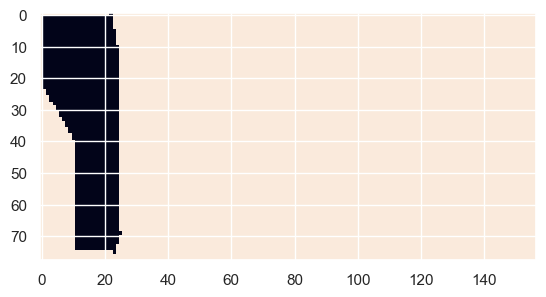

In [565]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

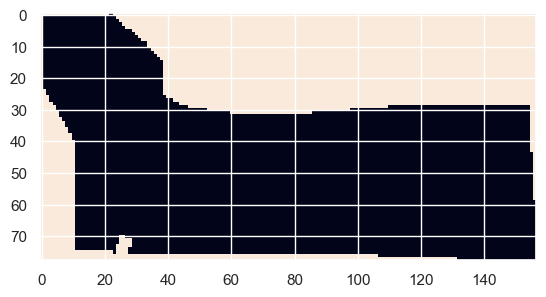

In [566]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [567]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Выбор порога облачности

In [636]:
white_noise_threshold = 255 # Значение [0-255]  
white_noise_count = 12246 # Количество 157*78=[0-12246]

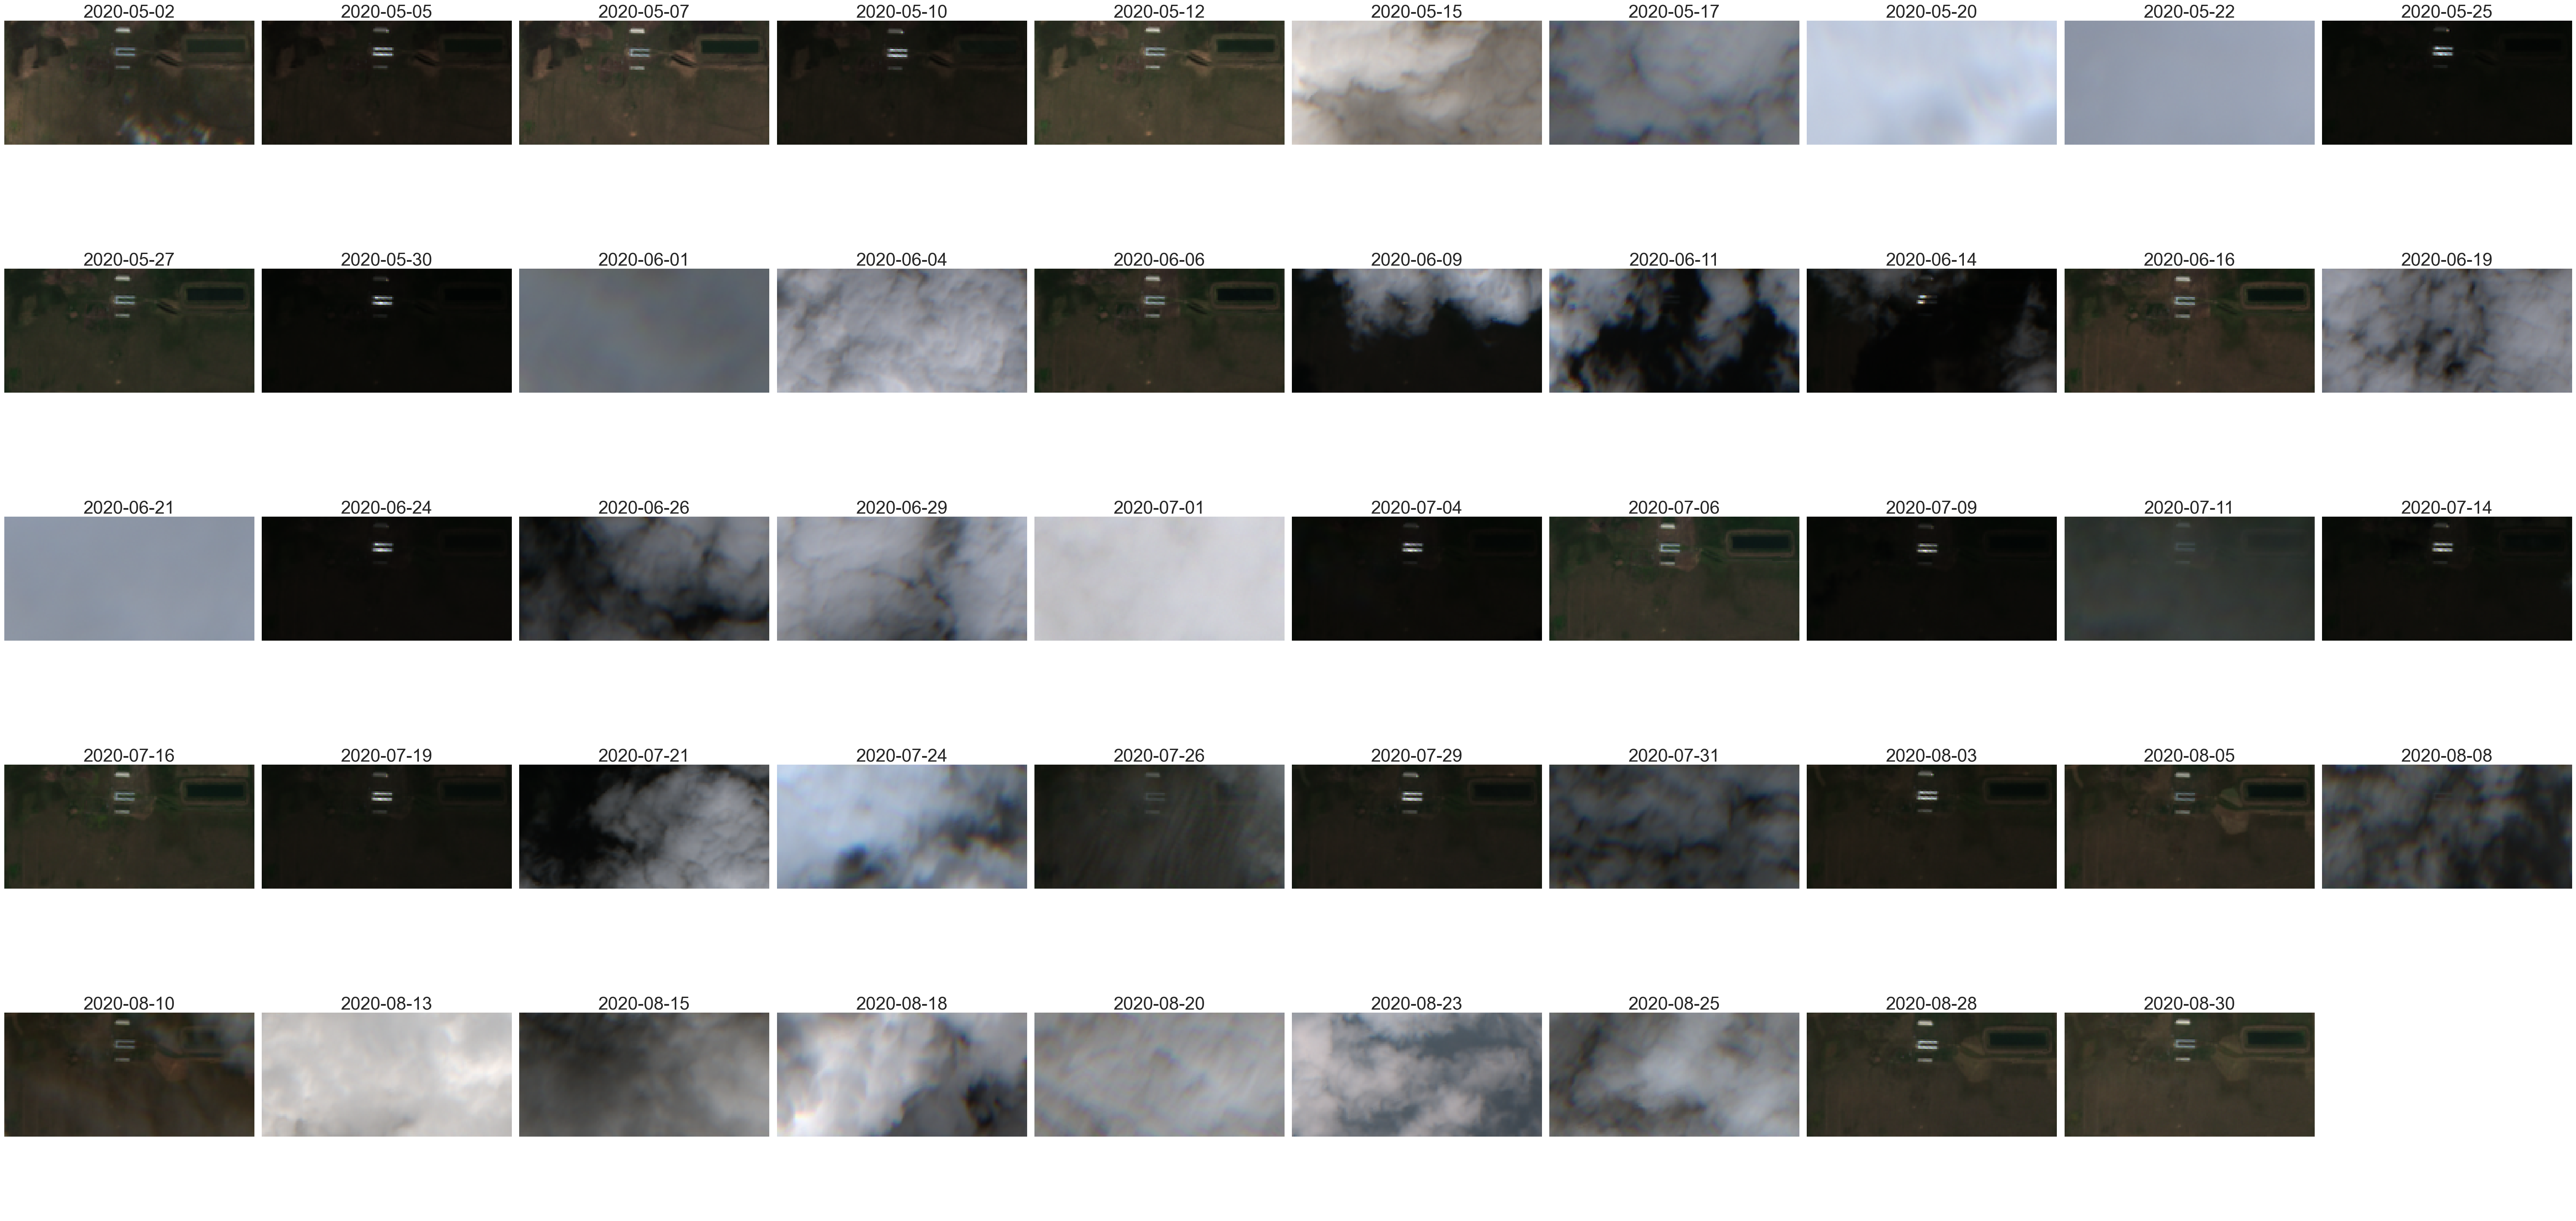

In [637]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

    data = image.astype(np.float64) / image.max()
    data = 255 * data
    image = data.astype(np.uint8)
    
    mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    comb = mx1&mx2&mx3
    white_image = comb >= white_noise_threshold
    if white_image.sum() <= white_noise_count:
    clear_date_dict.append((str(timestamp.date().isoformat()), i))
    ax = axis[idx // ncols][idx % ncols]
    image = np.stack([image[:,:,bands_dict["B04"]], image[:,:,bands_dict["B03"]], image[:,:,bands_dict["B02"]]])
    ax.imshow(np.transpose(image, (1, 2, 0)))
    ax.set_title(timestamp.date().isoformat(), fontsize=30)
    idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Выбор доступной даты 

In [581]:
date_chosen = "2020-07-11"
image_date = clear_date_dict[date_chosen]

get_all_bands(by_pasture=False)

precision = 4
general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level}"

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_9448\1730877722.py:3: RuntimeWarning: invalid value encountered in divide
  return ((band - band_min)/((band_max - band_min)))


# Исследование нового индекса

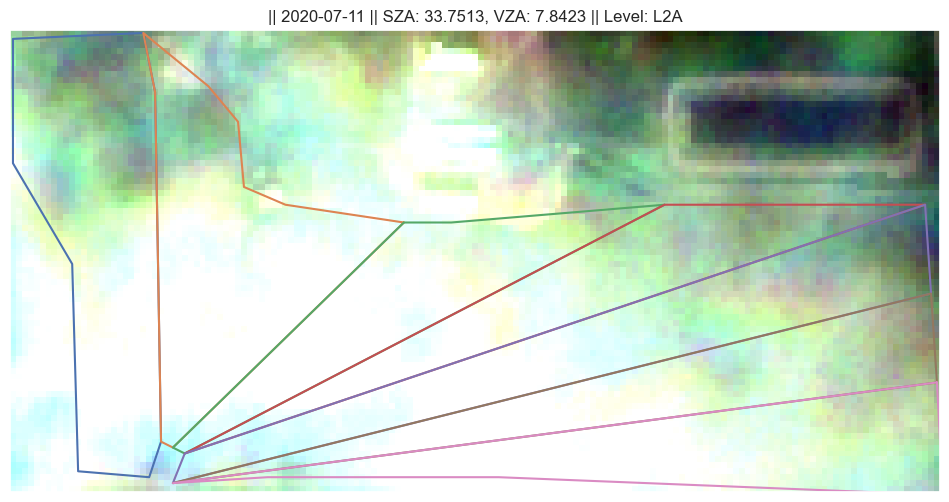

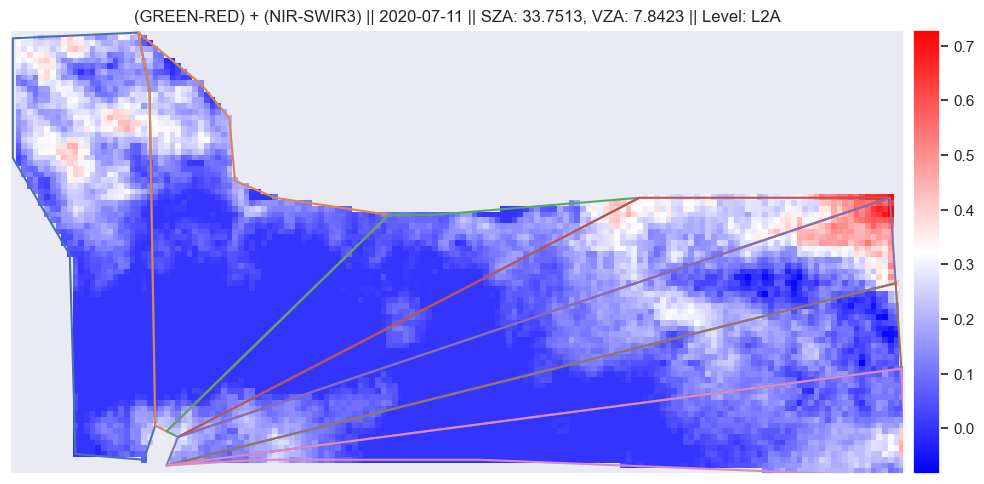

In [582]:
input_text = "(GREEN-RED) + (NIR-SWIR3)"
test_index = eval(input_text)

test_thresh = test_index.min() 
# test_thresh = (test_index.max() + test_index.min())/2

test_filter = test_index >= test_thresh; test_mask = ~test_filter
test_meet = ma.masked_array(test_index, mask=test_mask)

# lower_bound = -1;  upper_bound = 1
lower_bound = test_meet.min(); upper_bound = test_meet.max()

show_real_pasture()
show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=False, save_excel=False)

# Разбивка на кластеры

In [ ]:
# n_clusters = 3
# for cluster_mask in Kcluster(test_meet, n_clusters):
#     cluster = ma.masked_array(test_meet, mask=cluster_mask.reshape(aoi_height, aoi_width))
#     fig, ax = plt.subplots(figsize=(12, 12))
#     for zagon in range(len(pasture_df)-1):

#         ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

#     ep.plot_bands(cluster_mask, title=f"Кластер значении [{round(float(cluster.min()),precision)} - {round(float(cluster.max()),precision)}] канала {input_text} {general_info}", ax=ax, figsize=(10, 14))
# plt.show()

# Вывод всех каналов по отдельности

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(ULTRA_BLUE, cmap="Blues", vmin=ULTRA_BLUE.min(), vmax=ULTRA_BLUE.max())
plt.title(f"B01 Coastal Aerosol {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(BLUE, cmap="Blues", vmin=BLUE.min(), vmax=BLUE.max())
plt.title(f"B02 Blue {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(GREEN, cmap="Greens", vmin=GREEN.min(), vmax=GREEN.max())
plt.title(f"B03 Green {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED, cmap="Reds", vmin=RED.min(), vmax=RED.max())
plt.title(f"B04 Red {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE1, cmap="viridis", vmin=RED_EDGE1.min(), vmax=RED_EDGE1.max())
plt.title(f"B05 Red edge 1 {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE2, cmap="viridis", vmin=RED_EDGE2.min(), vmax=RED_EDGE2.max())
plt.title(f"B06 Red edge 2 {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE3, cmap="viridis", vmin=RED_EDGE3.min(), vmax=RED_EDGE3.max())
plt.title(f"B07 Red edge 3 {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(NIR, cmap="viridis", vmin=NIR.min(), vmax=NIR.max())
plt.title(f"B08 NIR {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(N_NIR, cmap="viridis", vmin=N_NIR.min(), vmax=N_NIR.max())
plt.title(f"B8A Narrow NIR {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(WV, cmap="viridis", vmin=WV.min(), vmax=WV.max())
plt.title(f"B09 Water vapor {general_info}")
plt.colorbar()
plt.show()

In [ ]:
if "B10" in bands_dict:
    fig, ax = plt.subplots(figsize=(12, 5))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    plt.imshow(SWIR_C, cmap="viridis", vmin=SWIR_C.min(), vmax=SWIR_C.max())
    plt.title(f"B10 SWIR C {general_info}")
    plt.colorbar()
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR2, cmap="viridis", vmin=SWIR2.min(), vmax=SWIR2.max())
plt.title(f"B11 SWIR 2 {general_info}")
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR3, cmap="viridis", vmin=SWIR3.min(), vmax=SWIR3.max())
plt.title(f"B11 SWIR 3 {general_info}")
plt.colorbar()
plt.show()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [599]:
longitude = pasture_bbox.geometry.centroid.coords.xy[0][0]
latitude = pasture_bbox.geometry.centroid.coords.xy[1][0]

In [600]:
forecast_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"showers_sum",
"snowfall_sum",
"precipitation_hours",
"precipitation_probability_max",
"precipitation_probability_min",
"precipitation_probability_mean",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",
"uv_index_max",
"uv_index_clear_sky_max",]

history_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"snowfall_sum",
"precipitation_hours",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",]


last_main_description = ""

def get_weather_mapping():
    global last_main_description
    
    url = "https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    weather_mapping = {}
    
    for i_table, table in enumerate(soup.select('table[BORDER]')):
        for i_row, row in enumerate(table.find_all('tr')[1:]):
            code_and_description = row.find_all('td')[:2]
            code = int(code_and_description[0].text.strip())
            description = code_and_description[1].text.strip()
            if not description.startswith("-"):
                last_main_description = description
            else:
                description = last_main_description
            weather_mapping[code] = description
            
            
    return weather_mapping

def weather_code_to_string(wmo_code):
    return weather_mapping.get(wmo_code, "Unknown Weather Code")

# Generate the weather mapping
weather_mapping = get_weather_mapping()


def apply_params_to_URL(URL, parameters):
    URL += "&daily="
    for i, parameter in enumerate(parameters):
        if i < len(parameters) - 1:
            URL += parameter + ","
        else:
            URL += parameter
    URL += "&timezone=auto"
    
    print("URL updated: ", URL)
    return URL

def make_API_request(URL):
    try:
        # Convert from bytes to text
        resp_text = urllib.request.urlopen(URL).read().decode('UTF-8')
        # Use loads to decode from text
        json_obj = json.loads(resp_text)
        print("Successfull API request!")
        return json_obj
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

# История погоды по заданному диапазону

In [601]:
start_date = "2022-05-01" 
end_date = "2022-08-31"

# start_date = time_interval[0]
# end_date = time_interval[1]

In [602]:
Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}"

In [603]:
Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)

URL updated:  https://archive-api.open-meteo.com/v1/archive?latitude=54.21495200000001&longitude=69.52020049999999&start_date=2022-05-01&end_date=2022-08-31&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto


In [604]:
history_json_obj = make_API_request(Hist_URL)

Successfull API request!


In [605]:
history_df = pd.DataFrame(history_json_obj["daily"])

In [606]:
history_df

time  temperature_2m_max  temperature_2m_min  \
0    2022-05-01                12.0                 4.4   
1    2022-05-02                11.4                 1.7   
2    2022-05-03                14.4                -1.8   
3    2022-05-04                17.4                 1.0   
4    2022-05-05                19.6                 7.8   
..          ...                 ...                 ...   
118  2022-08-27                21.4                14.8   
119  2022-08-28                21.1                 9.2   
120  2022-08-29                26.6                10.8   
121  2022-08-30                28.2                15.2   
122  2022-08-31                30.1                15.1   

     apparent_temperature_max  apparent_temperature_min  precipitation_sum  \
0                         7.1                       0.8                1.1   
1                         7.0                      -1.5                0.5   
2                         9.4                      -5.5                0.0   
3                        13.1                      -2.9                0.0   
4                        16.6                       4.0                0.0   
..                        ...                       ...                ...   
118                      19.3                      12.4                0.0   
119                      19.7                       7.4                0.0   
120                      25.1                       8.5                0.0   
121                      26.8                      14.5                0.3   
122                      27.8                      14.1                0.0   

     rain_sum  snowfall_sum  precipitation_hours  weathercode  \
0         1.1           0.0                  4.0           51   
1         0.5           0.0                  2.0           51   
2         0.0           0.0                  0.0            2   
3         0.0           0.0                  0.0            3   
4         0.0           0.0                  0.0            3   
..        ...           ...                  ...          ...   
118       0.0           0.0                  0.0            3   
119       0.0           0.0                  0.0            0   
120       0.0           0.0                  0.0            1   
121       0.3           0.0                  1.0           51   
122       0.0           0.0                  0.0            1   

              sunrise            sunset  windspeed_10m_max  windgusts_10m_max  \
0    2022-05-01T05:44  2022-05-01T20:53               19.3               42.1   
1    2022-05-02T05:42  2022-05-02T20:55               22.1               47.2   
2    2022-05-03T05:40  2022-05-03T20:57               17.3               38.2   
3    2022-05-04T05:38  2022-05-04T20:58               16.9               34.9   
4    2022-05-05T05:36  2022-05-05T21:00               15.8               28.1   
..                ...               ...                ...                ...   
118  2022-08-27T06:20  2022-08-27T20:26               14.8               32.0   
119  2022-08-28T06:22  2022-08-28T20:23                9.7               17.3   
120  2022-08-29T06:24  2022-08-29T20:21               11.9               26.3   
121  2022-08-30T06:26  2022-08-30T20:19               12.3               29.5   
122  2022-08-31T06:27  2022-08-31T20:16               12.1               28.1   

     winddirection_10m_dominant  shortwave_radiation_sum  \
0                            55                    12.63   
1                           141                    20.03   
2                           173                    20.37   
3                           302                    24.44   
4                           266                    17.86   
..                          ...                      ...   
118                          90                    17.26   
119                           0                    20.13   
120                         210                    19.31   
121        

In [607]:
dates_to_analyze = [
    '2022-08-25',
    '2022-08-28',
    '2022-08-30',
]

In [608]:
history_fraction_df = history_df[history_df['time'].isin(dates_to_analyze)]
history_fraction_df.reset_index(drop=True, inplace=True)
history_fraction_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_9448\3768268104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_fraction_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)


In [609]:
history_fraction_df

time  temperature_2m_max  temperature_2m_min  \
0  2022-08-25                26.0                13.3   
1  2022-08-28                21.1                 9.2   
2  2022-08-30                28.2                15.2   

   apparent_temperature_max  apparent_temperature_min  precipitation_sum  \
0                      25.3                      11.8                0.9   
1                      19.7                       7.4                0.0   
2                      26.8                      14.5                0.3   

   rain_sum  snowfall_sum  precipitation_hours  windspeed_10m_max  \
0       0.9           0.0                  4.0               12.4   
1       0.0           0.0                  0.0                9.7   
2       0.3           0.0                  1.0               12.3   

   windgusts_10m_max  winddirection_10m_dominant  shortwave_radiation_sum  \
0               27.7                         164                    18.14   
1               17.3                           0                    20.13   
2               29.5                         180                    18.74   

   et0_fao_evapotranspiration  
0                        3.83  
1                        3.48  
2                        4.35

# Дополнительная вспомогательная функция для сбора данных ДЗЗ

In [610]:
def get_date_data(date_chosen, collection, by_pasture=True, median=False):
    global bands_dict

    if collection == "L1C":
        data_collection = DataCollection.SENTINEL2_L1C
    elif collection == "L2A":
        data_collection = DataCollection.SENTINEL2_L2A

    bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
    aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

    evalscript_all_bands = """
        //VERSION=3
        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DN"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in bands_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
    evalscript_all_bands = evalscript_all_bands.format(**settings)


    evalscript_aux_data = """
        //VERSION=3

        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DEGREES"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in aux_data_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
    evalscript_aux_data = evalscript_aux_data.format(**settings)


    time_interval = date_chosen, date_chosen

    search_iterator = catalog.search(
        data_collection,
        bbox=pasture_bbox,
        time=time_interval,
        filter="eo:cloud_cover <= 100",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)

    time_difference = datetime.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)


    all_bands_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_all_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        all_bands_process_requests.append(request)

    aux_data_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_aux_data,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        aux_data_process_requests.append(request)

    client = SentinelHubDownloadClient(config=config)
    all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
    all_bands_data = client.download(all_bands_download_requests)

    client = SentinelHubDownloadClient(config=config)
    aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
    aux_data = client.download(aux_data_download_requests)

    white_noise_threshold = 255 # Значение [0-255]
    white_noise_count = 12246 # Количество 157*78=[0-12246]

    clear_date_dict = []
    for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

        data = image.astype(np.float64) / image.max()
        data = 255 * data
        image = data.astype(np.uint8)

        mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        comb = mx1&mx2&mx3
        white_image = comb >= white_noise_threshold
        if white_image.sum() <= white_noise_count:
            clear_date_dict.append((str(timestamp.date().isoformat()), i))

    clear_date_dict = dict(clear_date_dict)
    image_date = clear_date_dict[date_chosen]

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    ndvi = (NIR - RED) / (NIR + RED)
    savi = (NIR - RED) / (NIR + RED + 0.5) * (1 + 0.5)
    revi = (NIR / RED_EDGE1) - 1
    evi = 2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)
    tvi = np.sqrt((NIR - RED) / (NIR + RED) + 0.0)
    gndvi = (NIR - GREEN) / (NIR + GREEN)
    ndii = (NIR - SWIR3) / (NIR + SWIR3)
    cvi = (NIR / RED) - 1
    gci = (NIR / GREEN) - 1
    pri = (RED_EDGE1 - RED) / (RED_EDGE1 + RED)
    ndre = (NIR - RED_EDGE1) / (NIR + RED_EDGE1)
    osavi = (NIR - RED) / (NIR + RED + 0.16)
    arvi = (NIR - (2 * RED) + BLUE) / (NIR + (2 * RED) + BLUE)
    vari = (RED+BLUE-GREEN)
    my_index = (GREEN-RED)+(NIR-SWIR3)



    print(f"Успешно получены каналы для даты: {date_chosen}")
    if median:
        if "B10" in bands_dict:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.median(ULTRA_BLUE), ma.median(BLUE), ma.median(GREEN), ma.median(RED), ma.median(RED_EDGE1), ma.median(RED_EDGE2), ma.median(RED_EDGE3), ma.median(NIR), ma.median(N_NIR), ma.median(WV), ma.median(SWIR_C), ma.median(SWIR2), ma.median(SWIR3), ma.median(ndvi), ma.median(savi), ma.median(revi), ma.median(evi), ma.median(tvi), ma.median(gndvi), ma.median(ndii), ma.median(cvi), ma.median(gci), ma.median(pri), ma.median(ndre), ma.median(osavi), ma.median(arvi), ma.median(vari), ma.median(my_index), SZA, SAA, VZM, VAM]
        else:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.median(ULTRA_BLUE), ma.median(BLUE), ma.median(GREEN), ma.median(RED), ma.median(RED_EDGE1), ma.median(RED_EDGE2), ma.median(RED_EDGE3), ma.median(NIR), ma.median(N_NIR), ma.median(WV), ma.median(SWIR2), ma.median(SWIR3), ma.median(ndvi), ma.median(savi), ma.median(revi), ma.median(evi), ma.median(tvi), ma.median(gndvi), ma.median(ndii), ma.median(cvi), ma.median(gci), ma.median(pri), ma.median(ndre), ma.median(osavi), ma.median(arvi), ma.median(vari), ma.median(my_index), SZA, SAA, VZM, VAM]
    else:
        if "B10" in bands_dict:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.mean(ULTRA_BLUE), ma.mean(BLUE), ma.mean(GREEN), ma.mean(RED), ma.mean(RED_EDGE1), ma.mean(RED_EDGE2), ma.mean(RED_EDGE3), ma.mean(NIR), ma.mean(N_NIR), ma.mean(WV), ma.mean(SWIR_C), ma.mean(SWIR2), ma.mean(SWIR3), ma.mean(ndvi), ma.mean(savi), ma.mean(revi), ma.mean(evi), ma.mean(tvi), ma.mean(gndvi), ma.mean(ndii), ma.mean(cvi), ma.mean(gci), ma.mean(pri), ma.mean(ndre), ma.mean(osavi), ma.mean(arvi), ma.mean(vari), ma.mean(my_index), SZA, SAA, VZM, VAM]
        else:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.mean(ULTRA_BLUE), ma.mean(BLUE), ma.mean(GREEN), ma.mean(RED), ma.mean(RED_EDGE1), ma.mean(RED_EDGE2), ma.mean(RED_EDGE3), ma.mean(NIR), ma.mean(N_NIR), ma.mean(WV), ma.mean(SWIR2), ma.mean(SWIR3), ma.mean(ndvi), ma.mean(savi), ma.mean(revi), ma.mean(evi), ma.mean(tvi), ma.mean(gndvi), ma.mean(ndii), ma.mean(cvi), ma.mean(gci), ma.mean(pri), ma.mean(ndre), ma.mean(osavi), ma.mean(arvi), ma.mean(vari), ma.mean(my_index), SZA, SAA, VZM, VAM]

# Получение данных ДЗЗ по доступным датам

In [611]:
sample_form = []
for date in dates_to_analyze:
    data_lables, data_list = get_date_data(date, "L2A", by_pasture=False, median=False)
    sample_form.append(data_list)    

Успешно получены каналы для даты: 2022-08-25
Успешно получены каналы для даты: 2022-08-28
Успешно получены каналы для даты: 2022-08-30


In [612]:
indices_df = pd.DataFrame(sample_form, columns=data_lables)
# indices_df = indices_df[indices_df != "--"].dropna()
indices_df

time       B01       B02       B03       B04       B05       B06  \
0  2022-08-25  0.310770  0.215959  0.273310  0.339165  0.685588  1.000000   
1  2022-08-28  0.202207  0.145099  0.188599  0.222433  0.454126  0.907071   
2  2022-08-30  0.296497  0.151768  0.192206  0.242349  0.507694  0.957658   

        B07       B08       B8A  ...       pri      ndre     osavi      arvi  \
0  1.000000  1.000000  1.000000  ...  0.347892  0.189441  0.445646  0.295655   
1  0.971332  0.988679  0.997068  ...  0.355447  0.372861  0.562106  0.447345   
2  0.993520  0.996208  0.999935  ...  0.365851  0.327143  0.542577  0.417375   

       vari  my_index  sunZenithAngles  sunAzimuthAngles  viewZenithMean  \
0  0.281814 -0.058750        44.626400        162.341034        7.899986   
1  0.178934  0.047826        45.235409        166.303986        5.128539   
2  0.201911  0.005252        46.286797        163.337006        7.738314   

   viewAzimuthMean  
0       115.852806  
1       271.296661  
2       115.283600  

[3 rows x 32 columns]

# Подготовка таблиц

In [613]:
joined_df = pd.merge(indices_df, history_fraction_df, on='time', how='outer')
joined_df

time       B01       B02       B03       B04       B05       B06  \
0  2022-08-25  0.310770  0.215959  0.273310  0.339165  0.685588  1.000000   
1  2022-08-28  0.202207  0.145099  0.188599  0.222433  0.454126  0.907071   
2  2022-08-30  0.296497  0.151768  0.192206  0.242349  0.507694  0.957658   

        B07       B08       B8A  ...  apparent_temperature_min  \
0  1.000000  1.000000  1.000000  ...                      11.8   
1  0.971332  0.988679  0.997068  ...                       7.4   
2  0.993520  0.996208  0.999935  ...                      14.5   

   precipitation_sum  rain_sum  snowfall_sum  precipitation_hours  \
0                0.9       0.9           0.0                  4.0   
1                0.0       0.0           0.0                  0.0   
2                0.3       0.3           0.0                  1.0   

   windspeed_10m_max  windgusts_10m_max  winddirection_10m_dominant  \
0               12.4               27.7                         164   
1                9.7               17.3                           0   
2               12.3               29.5                         180   

   shortwave_radiation_sum  et0_fao_evapotranspiration  
0                    18.14                        3.83  
1                    20.13                        3.48  
2                    18.74                        4.35  

[3 rows x 45 columns]

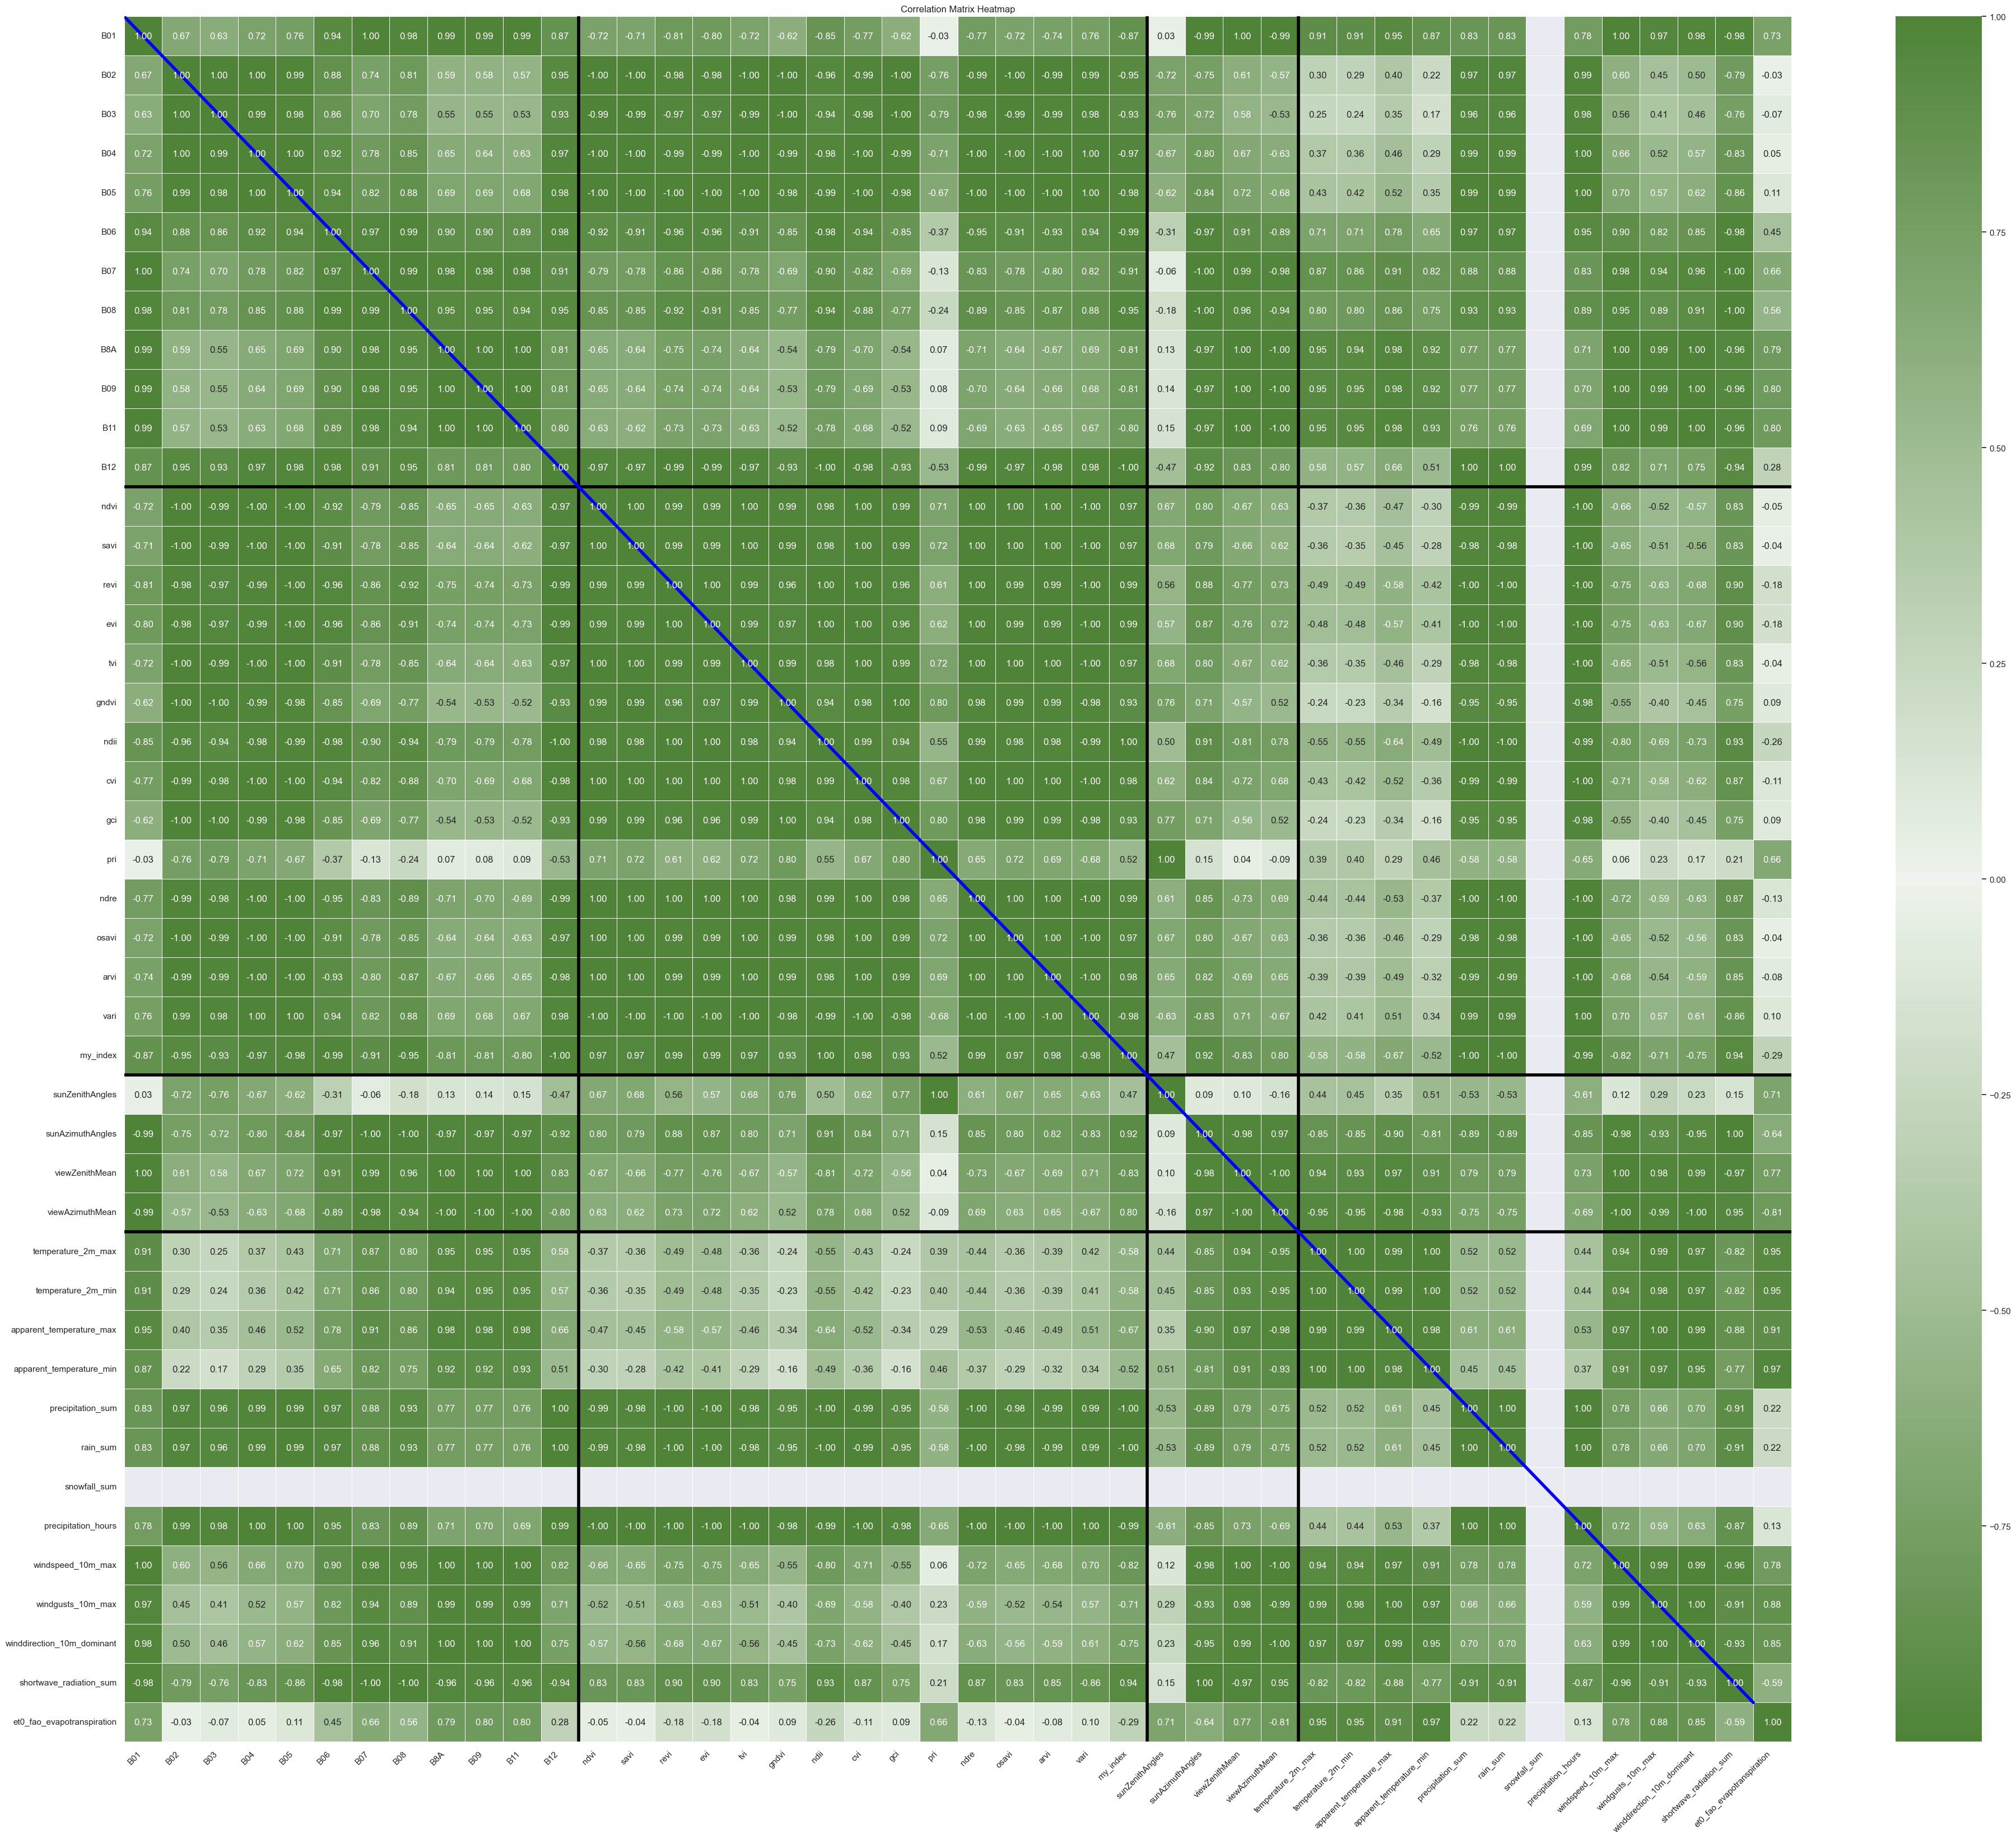

In [614]:
correlation_matrix = joined_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(48, 40))

cmap = sns.diverging_palette(120, 120, as_cmap=True)

# Plot the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Draw a separation line after the 5th column (index 4)
plt.axvline(x=12, color='black', linestyle='-', linewidth=4)
plt.axvline(x=27, color='black', linestyle='-', linewidth=4)
plt.axvline(x=31, color='black', linestyle='-', linewidth=4)

plt.axhline(y=12, color='black', linestyle='-', linewidth=4)
plt.axhline(y=27, color='black', linestyle='-', linewidth=4)
plt.axhline(y=31, color='black', linestyle='-', linewidth=4)

x = np.arange(correlation_matrix.shape[0])
plt.plot(x, x, color='blue', linestyle='-', linewidth=4)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.title("Correlation Matrix Heatmap")
plt.show()